In [1]:
from z3 import *
import numpy as np
import re
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

import os, sys
sys.path.append(os.path.join("../../../../"))

from src.mcmc_sat import smt, mcmc, sat, utils

# MCMC with SAT Sampler as Proposal Distribution

In this notebook, we show how to use the SAT sampler `cmsgen` to generate proposal samples for the Metropolis-Hastings algorithm.

## Model definition (in Z3)

We start by defining the model in Z3. It must be an SMT model using bit-vectors (BitVec). Instead of using a Z3 `Solver` object, we must use a `Goal` object. This is needed to later bit-blast automatically the SMT problem.

In [2]:
# Variation of Maja's model
# Taken from (Simson Garfinkel, John M. Abowd, Christian Martindale. Understanding Database Reconstruction Attacks on Public Data. Communications of the ACM, March 2019, Vol. 62 No. 3, Pages 46-53. DOI: 10.1145/3287287)

# Assumption, all bit-vectors are of the same size
num_bits = 8
num_vars = 5*2 # (age, gender)
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)] # 0-4 age vars, 5-9 sex vars
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)
g.add(sat.addition_does_not_overflow([x[0], x[1], x[2], x[3], x[4]]))
g.add(sat.addition_does_not_overflow([x[5], x[6], x[7], x[8], x[9]]))
for i in range(5):
    g.add(sat.multi_does_not_overflow([x[i],x[i+5]])) # this is in case of multiplication

# these are binary (obviously only for the purpose of the example)
# FEMALE = 0
# MALE = 1
for i in range(5,10):
    g.add(ULE(0,x[i]))
    g.add(ULE(x[i],1))


# establish an order to set the median
g.add(ULE(0,x[0]))
g.add(ULE(x[0],x[1]))
g.add(ULE(x[1],x[2]))
g.add(ULE(x[2],x[3]))
g.add(ULE(x[3],x[4]))
g.add(ULE(x[4],125))

g.add(x[2] == 30) # median

g.add(x[0] + x[1] + x[2] + x[3] + x[4] == 38*5) # average age

g.add(x[5] + x[6] + x[7] + x[8] + x[9] == 3) # only 3 males

g.add(x[0]*x[5] + x[1]*x[6] + x[2]*x[7] + x[3]*x[8] + x[4]*x[9] == 44*3) # average age of males

# NOTE: we might need to set an overflow constraint for the last sum.


In [3]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='cmsgen',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=10000, 
                                           num_chains=4)

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 00791438b32bb387e1f6ba7c1b211d7f6595aa06
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -fno-stack-protector -mtune=native -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DNDEBUG -D_FORTIFY_SOURCE=0 -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = ON | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING = ON | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = OFF | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 9.4.0
c executed with command line: cmsgen --samples 10000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing samples to file: cmsgen_input/cmsgen_samples.out
c Number of samples found until now:     10
c Number of samples found until now:     20
c Number of samples found until now:     30
c Number of samples fo

c Number of samples found until now:    130
c Number of samples found until now:    140
c Number of samples found until now:    150
c Number of samples found until now:    160
c Number of samples found until now:    170
c Number of samples found until now:    180
c Number of samples found until now:    190
c Number of samples found until now:    200
c Number of samples found until now:    210
c Number of samples found until now:    220
c Number of samples found until now:    230
c Number of samples found until now:    240
c Number of samples found until now:    250
c Number of samples found until now:    260
c Number of samples found until now:    270
c Number of samples found until now:    280


c Number of samples found until now:    290
c Number of samples found until now:    300
c Number of samples found until now:    310
c Number of samples found until now:    320
c Number of samples found until now:    330
c Number of samples found until now:    340
c Number of samples found until now:    350
c Number of samples found until now:    360
c Number of samples found until now:    370
c Number of samples found until now:    380
c Number of samples found until now:    390
c Number of samples found until now:    400
c Number of samples found until now:    410
c Number of samples found until now:    420
c Number of samples found until now:    430
c Number of samples found until now:    440
c Number of samples found until now:    450
c Number of samples found until now:    460
c Number of samples found until now:    470
c Number of samples found until now:    480
c Number of samples found until now:    490
c Number of samples found until now:    500
c Number of samples found until 

c Number of samples found until now:    520
c Number of samples found until now:    530
c Number of samples found until now:    540
c Number of samples found until now:    550
c Number of samples found until now:    560
c Number of samples found until now:    570
c Number of samples found until now:    580
c Number of samples found until now:    590
c Number of samples found until now:    600
c Number of samples found until now:    610
c Number of samples found until now:    620
c Number of samples found until now:    630
c Number of samples found until now:    640
c Number of samples found until now:    650
c Number of samples found until now:    660
c Number of samples found until now:    670
c Number of samples found until now:    680
c Number of samples found until now:    690
c Number of samples found until now:    700
c Number of samples found until now:    710
c Number of samples found until now:    720
c Number of samples found until now:    730
c Number of samples found until 

c Number of samples found until now:    810
c Number of samples found until now:    820
c Number of samples found until now:    830
c Number of samples found until now:    840
c Number of samples found until now:    850
c Number of samples found until now:    860
c Number of samples found until now:    870
c Number of samples found until now:    880
c Number of samples found until now:    890
c Number of samples found until now:    900
c Number of samples found until now:    910
c Number of samples found until now:    920
c Number of samples found until now:    930
c Number of samples found until now:    940
c Number of samples found until now:    950
c Number of samples found until now:    960
c Number of samples found until now:    970
c Number of samples found until now:    980
c Number of samples found until now:    990
c Number of samples found until now:   1000
c Number of samples found until now:   1010
c Number of samples found until now:   1020
c Number of samples found until 

c Number of samples found until now:   1060
c Number of samples found until now:   1070
c Number of samples found until now:   1080
c Number of samples found until now:   1090
c Number of samples found until now:   1100
c Number of samples found until now:   1110
c Number of samples found until now:   1120
c Number of samples found until now:   1130
c Number of samples found until now:   1140
c Number of samples found until now:   1150
c Number of samples found until now:   1160
c Number of samples found until now:   1170
c Number of samples found until now:   1180
c Number of samples found until now:   1190
c Number of samples found until now:   1200
c Number of samples found until now:   1210
c Number of samples found until now:   1220
c Number of samples found until now:   1230
c Number of samples found until now:   1240
c Number of samples found until now:   1250
c Number of samples found until now:   1260
c Number of samples found until now:   1270
c Number of samples found until 

c Number of samples found until now:   1400
c Number of samples found until now:   1410
c Number of samples found until now:   1420
c Number of samples found until now:   1430
c Number of samples found until now:   1440
c Number of samples found until now:   1450
c Number of samples found until now:   1460
c Number of samples found until now:   1470
c Number of samples found until now:   1480
c Number of samples found until now:   1490
c Number of samples found until now:   1500
c Number of samples found until now:   1510
c Number of samples found until now:   1520
c Number of samples found until now:   1530
c Number of samples found until now:   1540
c Number of samples found until now:   1550
c Number of samples found until now:   1560
c Number of samples found until now:   1570
c Number of samples found until now:   1580
c Number of samples found until now:   1590
c Number of samples found until now:   1600
c Number of samples found until now:   1610
c Number of samples found until 

c Number of samples found until now:   1770
c Number of samples found until now:   1780
c Number of samples found until now:   1790
c Number of samples found until now:   1800
c Number of samples found until now:   1810
c Number of samples found until now:   1820
c Number of samples found until now:   1830
c Number of samples found until now:   1840
c Number of samples found until now:   1850
c Number of samples found until now:   1860
c Number of samples found until now:   1870
c Number of samples found until now:   1880
c Number of samples found until now:   1890
c Number of samples found until now:   1900
c Number of samples found until now:   1910
c Number of samples found until now:   1920
c Number of samples found until now:   1930
c Number of samples found until now:   1940
c Number of samples found until now:   1950
c Number of samples found until now:   1960
c Number of samples found until now:   1970
c Number of samples found until now:   1980
c Number of samples found until 

c Number of samples found until now:   2120
c Number of samples found until now:   2130
c Number of samples found until now:   2140
c Number of samples found until now:   2150
c Number of samples found until now:   2160
c Number of samples found until now:   2170
c Number of samples found until now:   2180
c Number of samples found until now:   2190
c Number of samples found until now:   2200
c Number of samples found until now:   2210
c Number of samples found until now:   2220
c Number of samples found until now:   2230
c Number of samples found until now:   2240
c Number of samples found until now:   2250
c Number of samples found until now:   2260
c Number of samples found until now:   2270
c Number of samples found until now:   2280
c Number of samples found until now:   2290
c Number of samples found until now:   2300
c Number of samples found until now:   2310
c Number of samples found until now:   2320
c Number of samples found until now:   2330
c Number of samples found until 

c Number of samples found until now:   2460
c Number of samples found until now:   2470
c Number of samples found until now:   2480
c Number of samples found until now:   2490
c Number of samples found until now:   2500
c Number of samples found until now:   2510
c Number of samples found until now:   2520
c Number of samples found until now:   2530
c Number of samples found until now:   2540
c Number of samples found until now:   2550
c Number of samples found until now:   2560
c Number of samples found until now:   2570
c Number of samples found until now:   2580
c Number of samples found until now:   2590
c Number of samples found until now:   2600
c Number of samples found until now:   2610
c Number of samples found until now:   2620
c Number of samples found until now:   2630
c Number of samples found until now:   2640
c Number of samples found until now:   2650
c Number of samples found until now:   2660
c Number of samples found until now:   2670
c Number of samples found until 

c Number of samples found until now:   2850
c Number of samples found until now:   2860
c Number of samples found until now:   2870
c Number of samples found until now:   2880
c Number of samples found until now:   2890
c Number of samples found until now:   2900
c Number of samples found until now:   2910
c Number of samples found until now:   2920
c Number of samples found until now:   2930
c Number of samples found until now:   2940
c Number of samples found until now:   2950
c Number of samples found until now:   2960
c Number of samples found until now:   2970
c Number of samples found until now:   2980
c Number of samples found until now:   2990
c Number of samples found until now:   3000
c Number of samples found until now:   3010
c Number of samples found until now:   3020
c Number of samples found until now:   3030
c Number of samples found until now:   3040
c Number of samples found until now:   3050
c Number of samples found until now:   3060
c Number of samples found until 

c Number of samples found until now:   3180
c Number of samples found until now:   3190
c Number of samples found until now:   3200
c Number of samples found until now:   3210
c Number of samples found until now:   3220
c Number of samples found until now:   3230
c Number of samples found until now:   3240
c Number of samples found until now:   3250
c Number of samples found until now:   3260
c Number of samples found until now:   3270
c Number of samples found until now:   3280
c Number of samples found until now:   3290
c Number of samples found until now:   3300
c Number of samples found until now:   3310
c Number of samples found until now:   3320
c Number of samples found until now:   3330
c Number of samples found until now:   3340
c Number of samples found until now:   3350
c Number of samples found until now:   3360
c Number of samples found until now:   3370
c Number of samples found until now:   3380
c Number of samples found until now:   3390
c Number of samples found until 

c Number of samples found until now:   3580
c Number of samples found until now:   3590
c Number of samples found until now:   3600
c Number of samples found until now:   3610
c Number of samples found until now:   3620
c Number of samples found until now:   3630
c Number of samples found until now:   3640
c Number of samples found until now:   3650
c Number of samples found until now:   3660
c Number of samples found until now:   3670
c Number of samples found until now:   3680
c Number of samples found until now:   3690


c Number of samples found until now:   3700
c Number of samples found until now:   3710
c Number of samples found until now:   3720
c Number of samples found until now:   3730
c Number of samples found until now:   3740
c Number of samples found until now:   3750
c Number of samples found until now:   3760
c Number of samples found until now:   3770
c Number of samples found until now:   3780
c Number of samples found until now:   3790
c Number of samples found until now:   3800
c Number of samples found until now:   3810
c Number of samples found until now:   3820
c Number of samples found until now:   3830
c Number of samples found until now:   3840
c Number of samples found until now:   3850
c Number of samples found until now:   3860
c Number of samples found until now:   3870
c Number of samples found until now:   3880
c Number of samples found until now:   3890
c Number of samples found until now:   3900
c Number of samples found until now:   3910
c Number of samples found until 

c Number of samples found until now:   4130
c Number of samples found until now:   4140
c Number of samples found until now:   4150
c Number of samples found until now:   4160
c Number of samples found until now:   4170
c Number of samples found until now:   4180
c Number of samples found until now:   4190
c Number of samples found until now:   4200
c Number of samples found until now:   4210
c Number of samples found until now:   4220
c Number of samples found until now:   4230
c Number of samples found until now:   4240
c Number of samples found until now:   4250
c Number of samples found until now:   4260
c Number of samples found until now:   4270
c Number of samples found until now:   4280
c Number of samples found until now:   4290
c Number of samples found until now:   4300
c Number of samples found until now:   4310
c Number of samples found until now:   4320
c Number of samples found until now:   4330
c Number of samples found until now:   4340
c Number of samples found until 

c Number of samples found until now:   4530
c Number of samples found until now:   4540
c Number of samples found until now:   4550
c Number of samples found until now:   4560
c Number of samples found until now:   4570
c Number of samples found until now:   4580
c Number of samples found until now:   4590
c Number of samples found until now:   4600
c Number of samples found until now:   4610
c Number of samples found until now:   4620
c Number of samples found until now:   4630
c Number of samples found until now:   4640
c Number of samples found until now:   4650
c Number of samples found until now:   4660
c Number of samples found until now:   4670
c Number of samples found until now:   4680
c Number of samples found until now:   4690
c Number of samples found until now:   4700
c Number of samples found until now:   4710
c Number of samples found until now:   4720
c Number of samples found until now:   4730
c Number of samples found until now:   4740
c Number of samples found until 

c Number of samples found until now:   4960
c Number of samples found until now:   4970
c Number of samples found until now:   4980
c Number of samples found until now:   4990
c Number of samples found until now:   5000
c Number of samples found until now:   5010
c Number of samples found until now:   5020
c Number of samples found until now:   5030
c Number of samples found until now:   5040
c Number of samples found until now:   5050
c Number of samples found until now:   5060
c Number of samples found until now:   5070
c Number of samples found until now:   5080
c Number of samples found until now:   5090
c Number of samples found until now:   5100
c Number of samples found until now:   5110
c Number of samples found until now:   5120
c Number of samples found until now:   5130
c Number of samples found until now:   5140
c Number of samples found until now:   5150
c Number of samples found until now:   5160
c Number of samples found until now:   5170
c Number of samples found until 

c Number of samples found until now:   5380
c Number of samples found until now:   5390
c Number of samples found until now:   5400
c Number of samples found until now:   5410
c Number of samples found until now:   5420
c Number of samples found until now:   5430
c Number of samples found until now:   5440
c Number of samples found until now:   5450
c Number of samples found until now:   5460
c Number of samples found until now:   5470
c Number of samples found until now:   5480
c Number of samples found until now:   5490
c Number of samples found until now:   5500
c Number of samples found until now:   5510
c Number of samples found until now:   5520
c Number of samples found until now:   5530
c Number of samples found until now:   5540
c Number of samples found until now:   5550
c Number of samples found until now:   5560
c Number of samples found until now:   5570
c Number of samples found until now:   5580
c Number of samples found until now:   5590
c Number of samples found until 

c Number of samples found until now:   5750
c Number of samples found until now:   5760
c Number of samples found until now:   5770
c Number of samples found until now:   5780
c Number of samples found until now:   5790
c Number of samples found until now:   5800
c Number of samples found until now:   5810
c Number of samples found until now:   5820
c Number of samples found until now:   5830
c Number of samples found until now:   5840
c Number of samples found until now:   5850
c Number of samples found until now:   5860
c Number of samples found until now:   5870
c Number of samples found until now:   5880
c Number of samples found until now:   5890
c Number of samples found until now:   5900
c Number of samples found until now:   5910
c Number of samples found until now:   5920
c Number of samples found until now:   5930
c Number of samples found until now:   5940
c Number of samples found until now:   5950
c Number of samples found until now:   5960
c Number of samples found until 

c Number of samples found until now:   6170
c Number of samples found until now:   6180
c Number of samples found until now:   6190
c Number of samples found until now:   6200
c Number of samples found until now:   6210
c Number of samples found until now:   6220
c Number of samples found until now:   6230
c Number of samples found until now:   6240
c Number of samples found until now:   6250
c Number of samples found until now:   6260
c Number of samples found until now:   6270
c Number of samples found until now:   6280
c Number of samples found until now:   6290
c Number of samples found until now:   6300
c Number of samples found until now:   6310
c Number of samples found until now:   6320
c Number of samples found until now:   6330
c Number of samples found until now:   6340
c Number of samples found until now:   6350
c Number of samples found until now:   6360
c Number of samples found until now:   6370
c Number of samples found until now:   6380
c Number of samples found until 

c Number of samples found until now:   6580
c Number of samples found until now:   6590
c Number of samples found until now:   6600
c Number of samples found until now:   6610
c Number of samples found until now:   6620
c Number of samples found until now:   6630
c Number of samples found until now:   6640
c Number of samples found until now:   6650
c Number of samples found until now:   6660
c Number of samples found until now:   6670
c Number of samples found until now:   6680
c Number of samples found until now:   6690
c Number of samples found until now:   6700
c Number of samples found until now:   6710
c Number of samples found until now:   6720
c Number of samples found until now:   6730
c Number of samples found until now:   6740
c Number of samples found until now:   6750
c Number of samples found until now:   6760
c Number of samples found until now:   6770
c Number of samples found until now:   6780
c Number of samples found until now:   6790
c Number of samples found until 

c Number of samples found until now:   7010
c Number of samples found until now:   7020
c Number of samples found until now:   7030
c Number of samples found until now:   7040
c Number of samples found until now:   7050
c Number of samples found until now:   7060
c Number of samples found until now:   7070
c Number of samples found until now:   7080
c Number of samples found until now:   7090
c Number of samples found until now:   7100
c Number of samples found until now:   7110
c Number of samples found until now:   7120
c Number of samples found until now:   7130
c Number of samples found until now:   7140
c Number of samples found until now:   7150
c Number of samples found until now:   7160
c Number of samples found until now:   7170
c Number of samples found until now:   7180
c Number of samples found until now:   7190
c Number of samples found until now:   7200
c Number of samples found until now:   7210
c Number of samples found until now:   7220
c Number of samples found until 

c Number of samples found until now:   7440
c Number of samples found until now:   7450
c Number of samples found until now:   7460
c Number of samples found until now:   7470
c Number of samples found until now:   7480
c Number of samples found until now:   7490
c Number of samples found until now:   7500
c Number of samples found until now:   7510
c Number of samples found until now:   7520
c Number of samples found until now:   7530
c Number of samples found until now:   7540
c Number of samples found until now:   7550
c Number of samples found until now:   7560
c Number of samples found until now:   7570
c Number of samples found until now:   7580
c Number of samples found until now:   7590
c Number of samples found until now:   7600
c Number of samples found until now:   7610
c Number of samples found until now:   7620
c Number of samples found until now:   7630
c Number of samples found until now:   7640
c Number of samples found until now:   7650
c Number of samples found until 

c Number of samples found until now:   7860
c Number of samples found until now:   7870
c Number of samples found until now:   7880
c Number of samples found until now:   7890
c Number of samples found until now:   7900
c Number of samples found until now:   7910
c Number of samples found until now:   7920
c Number of samples found until now:   7930
c Number of samples found until now:   7940
c Number of samples found until now:   7950
c Number of samples found until now:   7960
c Number of samples found until now:   7970
c Number of samples found until now:   7980
c Number of samples found until now:   7990
c Number of samples found until now:   8000
c Number of samples found until now:   8010
c Number of samples found until now:   8020
c Number of samples found until now:   8030
c Number of samples found until now:   8040
c Number of samples found until now:   8050
c Number of samples found until now:   8060
c Number of samples found until now:   8070
c Number of samples found until 

c Number of samples found until now:   8290
c Number of samples found until now:   8300
c Number of samples found until now:   8310
c Number of samples found until now:   8320
c Number of samples found until now:   8330
c Number of samples found until now:   8340
c Number of samples found until now:   8350
c Number of samples found until now:   8360
c Number of samples found until now:   8370
c Number of samples found until now:   8380
c Number of samples found until now:   8390
c Number of samples found until now:   8400
c Number of samples found until now:   8410
c Number of samples found until now:   8420
c Number of samples found until now:   8430
c Number of samples found until now:   8440
c Number of samples found until now:   8450
c Number of samples found until now:   8460
c Number of samples found until now:   8470
c Number of samples found until now:   8480
c Number of samples found until now:   8490
c Number of samples found until now:   8500
c Number of samples found until 

c Number of samples found until now:   8690
c Number of samples found until now:   8700
c Number of samples found until now:   8710
c Number of samples found until now:   8720
c Number of samples found until now:   8730
c Number of samples found until now:   8740
c Number of samples found until now:   8750
c Number of samples found until now:   8760
c Number of samples found until now:   8770
c Number of samples found until now:   8780
c Number of samples found until now:   8790
c Number of samples found until now:   8800
c Number of samples found until now:   8810
c Number of samples found until now:   8820
c Number of samples found until now:   8830
c Number of samples found until now:   8840
c Number of samples found until now:   8850
c Number of samples found until now:   8860
c Number of samples found until now:   8870
c Number of samples found until now:   8880
c Number of samples found until now:   8890
c Number of samples found until now:   8900
c Number of samples found until 

c Number of samples found until now:   9100
c Number of samples found until now:   9110
c Number of samples found until now:   9120
c Number of samples found until now:   9130
c Number of samples found until now:   9140
c Number of samples found until now:   9150
c Number of samples found until now:   9160
c Number of samples found until now:   9170
c Number of samples found until now:   9180
c Number of samples found until now:   9190
c Number of samples found until now:   9200
c Number of samples found until now:   9210
c Number of samples found until now:   9220
c Number of samples found until now:   9230
c Number of samples found until now:   9240
c Number of samples found until now:   9250
c Number of samples found until now:   9260
c Number of samples found until now:   9270
c Number of samples found until now:   9280
c Number of samples found until now:   9290
c Number of samples found until now:   9300
c Number of samples found until now:   9310
c Number of samples found until 

c Number of samples found until now:   9510
c Number of samples found until now:   9520
c Number of samples found until now:   9530
c Number of samples found until now:   9540
c Number of samples found until now:   9550
c Number of samples found until now:   9560
c Number of samples found until now:   9570
c Number of samples found until now:   9580
c Number of samples found until now:   9590
c Number of samples found until now:   9600
c Number of samples found until now:   9610
c Number of samples found until now:   9620
c Number of samples found until now:   9630
c Number of samples found until now:   9640
c Number of samples found until now:   9650
c Number of samples found until now:   9660
c Number of samples found until now:   9670
c Number of samples found until now:   9680
c Number of samples found until now:   9690
c Number of samples found until now:   9700
c Number of samples found until now:   9710
c Number of samples found until now:   9720
c Number of samples found until 

c Number of samples found until now:   9920
c Number of samples found until now:   9930
c Number of samples found until now:   9940
c Number of samples found until now:   9950
c Number of samples found until now:   9960
c Number of samples found until now:   9970
c Number of samples found until now:   9980
c Number of samples found until now:   9990
c Finished generating all 10000 samples
c Total time: 5.8 s 


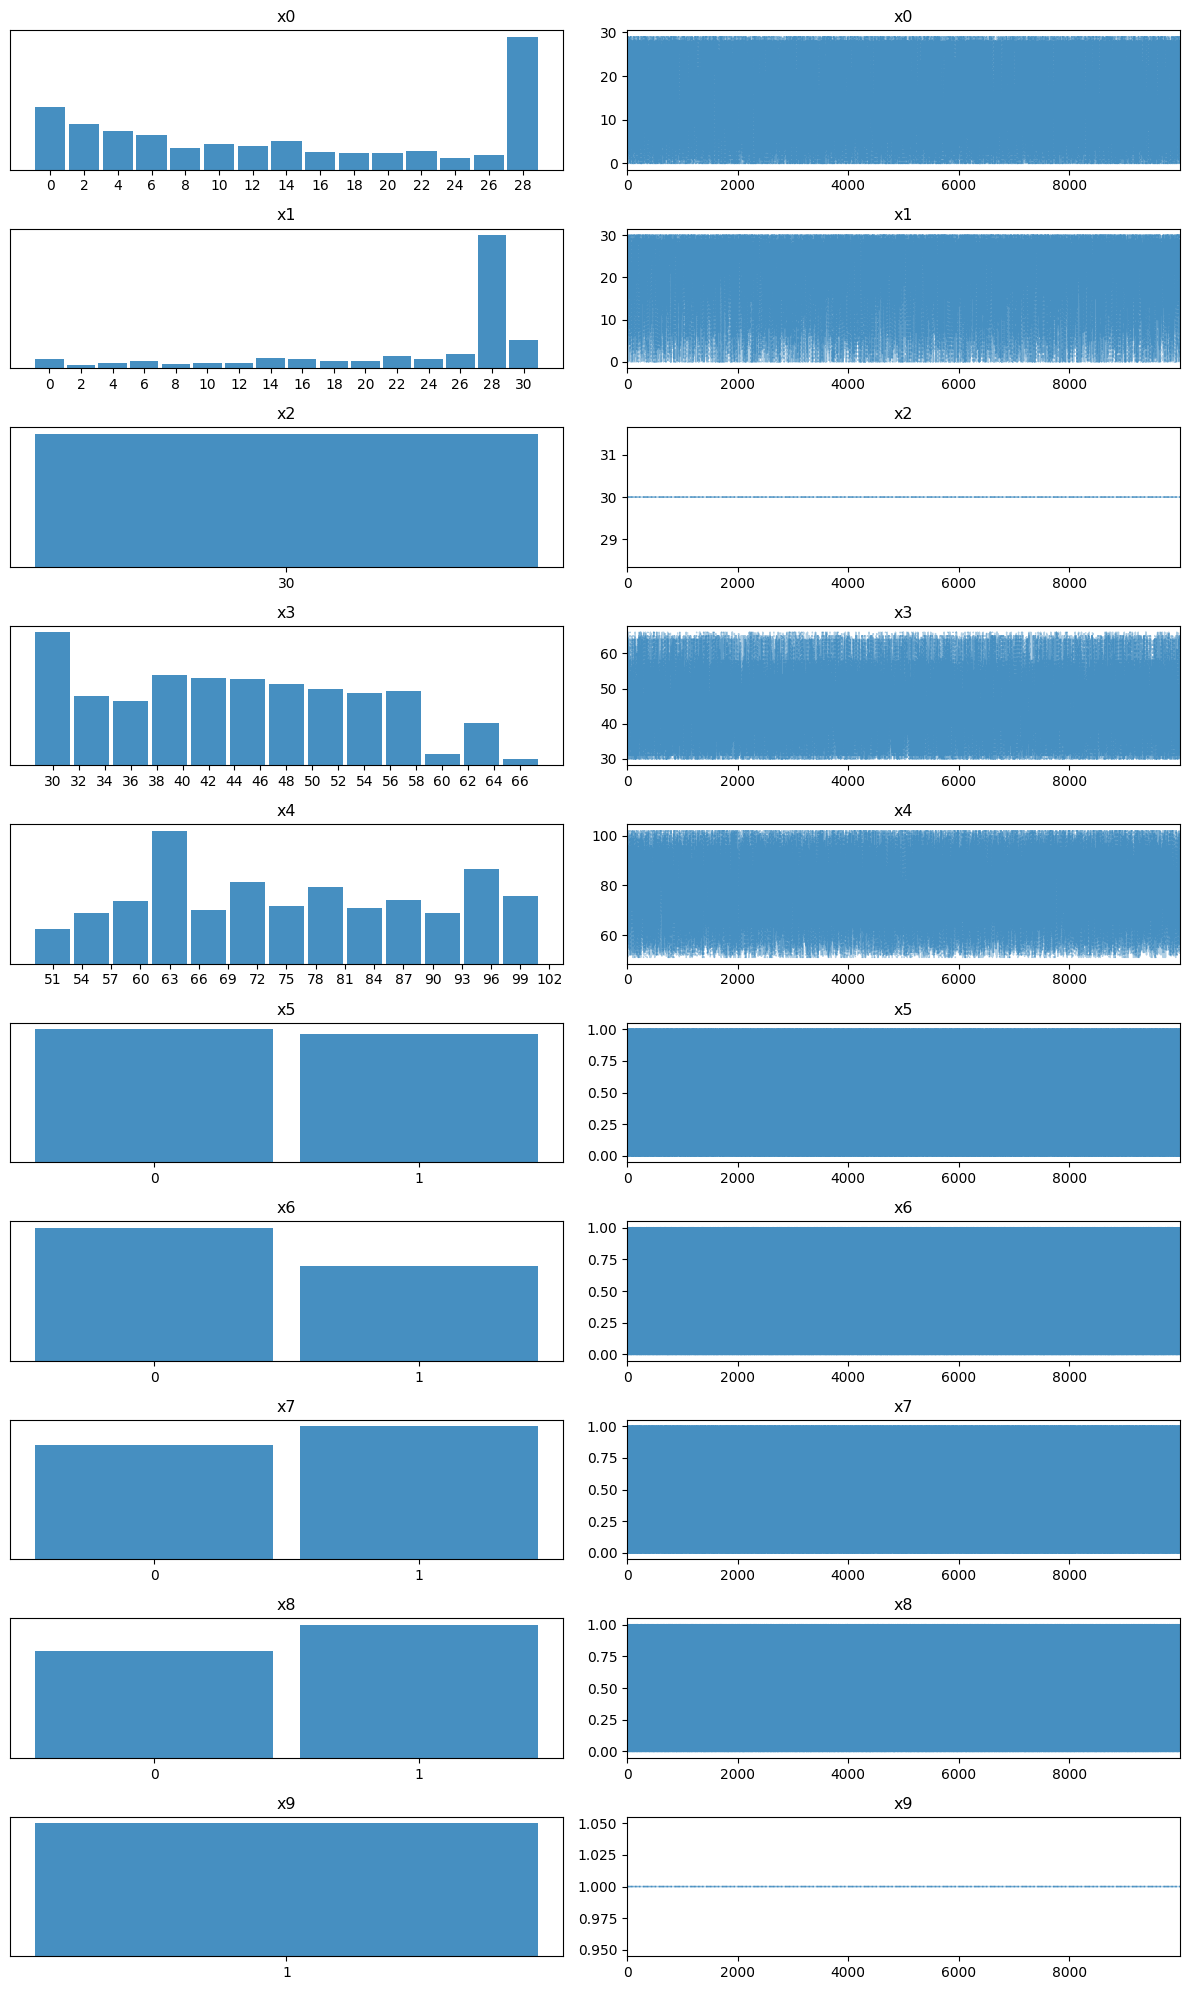

In [4]:
# Trace plot
az.plot_trace(trace);
plt.savefig('cmsgen_trace_plot.png', dpi=150);

In [5]:
# Diagnosis
az.summary(trace)

/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc+sat/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,14.660,10.561,0.0,28.0,0.053,0.037,39673.0,40000.0,1.0
x1,23.282,8.308,5.0,30.0,0.041,0.029,40091.0,40000.0,1.0
x2,30.000,0.000,30.0,30.0,0.000,0.000,40000.0,40000.0,NaN
x3,44.958,9.889,30.0,61.0,0.050,0.035,39832.0,38678.0,1.0
x4,77.101,14.464,56.0,102.0,0.072,0.051,39928.0,39589.0,1.0
x5,0.491,0.500,0.0,1.0,0.002,0.002,40151.0,40000.0,1.0
x6,0.416,0.493,0.0,1.0,0.002,0.002,40085.0,40000.0,1.0
x7,0.538,0.499,0.0,1.0,0.002,0.002,39837.0,39837.0,1.0
x8,0.554,0.497,0.0,1.0,0.002,0.002,39645.0,39645.0,1.0
x9,1.000,0.000,1.0,1.0,0.000,0.000,40000.0,40000.0,NaN


In [6]:
utils.save_trace(trace, f'db_cacm_SAT_cmsgen_{num_vars}_{num_bits}.nc')